In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


In [2]:
def init(N):
    return np.random.choice([-1, 1], N)


def gen_neigh(L):
    N = L**2

    neigh = np.empty((N, 4), dtype=np.int16)

    for i in range(N):
        if i % L == L - 1:  # dir
            right = i - L + 1
        else:
            right = i + 1

        neigh[i][0] = right

        if i >= (L**2) - L:  # cima
            up = i - N + L
        else:
            up = i + L

        neigh[i][1] = up

        if i % L == 0:  # esq
            left = i + L - 1
        else:
            left = i - 1

        neigh[i][2] = left

        if i < L:  # baixo
            down = i + N - L
        else:
            down = i - L

        neigh[i][3] = down

    return neigh


@jit(nopython=True)
def calc_energy(spins, neigh):
    N = len(spins)
    energy = 0

    for i in range(N):
        neigh_i = neigh[i][0:2]

        for j in neigh_i:
            energy -= spins[i] * spins[j]

    mag = np.sum(spins)
    return energy, mag


# energy difference when i is flipped
@jit(nopython=True)
def en_diff(i, spins, neigh):
    sum = 0

    for j in neigh[i]:
        sum += spins[j]

    delta = 2 * spins[i] * sum

    return delta


@jit(nopython=True)
def get_expos(T):
    expos = np.zeros(5, dtype=np.float32)
    expos[0] = np.exp(8 / T)
    expos[1] = np.exp(4 / T)
    expos[2] = 1
    expos[3] = np.exp(-4 / T)
    expos[4] = np.exp(-8 / T)

    return expos


@jit(nopython=True)
def mc_step(spins, energy, mag, neigh, expos):
    N = len(spins)
    for i in range(N):
        delta_e = en_diff(i, spins, neigh)

        de = int(delta_e*0.25 + 2)
        P = expos[de]
        r = np.random.rand()

        if r <= P:
            spins[i] = -spins[i]
            energy += delta_e
            mag = mag + 2*spins[i]

    return spins, energy, mag


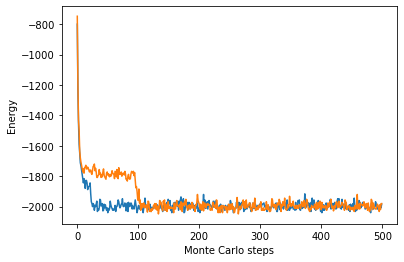

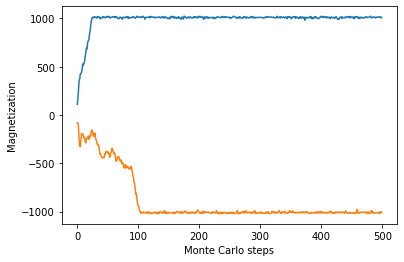

In [3]:
L = 32
N = L**2
T = 1.5
neigh = gen_neigh(L)
expos = get_expos(T)

fig, ax = plt.subplots()
ax.set_xlabel("Monte Carlo steps")
ax.set_ylabel("Energy")

fig, ax_mag = plt.subplots()
ax_mag.set_xlabel("Monte Carlo steps")
ax_mag.set_ylabel("Magnetization")

for i in range(2):
    spins = init(N)
    energy, mag = calc_energy(spins, neigh)

    energies = []
    mags = []

    for _ in range(500):
        spins, energy, mag = mc_step(spins, energy, mag, neigh, expos)

        energies.append(energy)
        mags.append(mag)

    ax.plot(energies)
    ax_mag.plot(mags)

plt.show()

<ErrorbarContainer object of 3 artists>

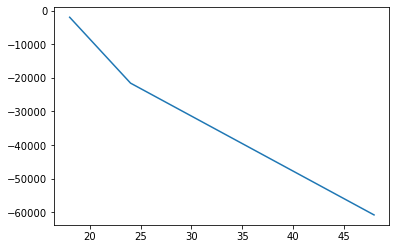

In [4]:
net_sizes = [18, 24, 36, 48]
temperatures = np.arange(2, 3, 0.1)

dt = np.dtype([('energy', np.float)])
data = np.empty((len(net_sizes), len(temperatures)), dtype=dt)

num_steps = int(1.1 * 10**3)
thermaliz_time = 10**1
n_boxes = 10
m = (num_steps - thermaliz_time)/n_boxes

energy_box = []
energy2_box = []

for L_index, L in enumerate(net_sizes):
  spins = init(N)
  energy, mag = calc_energy(spins, neigh)

  for t_index, temper in enumerate(temperatures):
    en_sum = 0
    en2_sum = 0

    for j in range(num_steps):
      spins, energy, mag = mc_step(spins, energy, mag, neigh, expos)

      if (j < thermaliz_time): continue

      if (j % (m - 1) == 0):
        energy_box.append(en_sum/m)
        energy2_box.append(en2_sum/m)
        en_sum = 0
        en2_sum = 0

      en_sum += energy
      en2_sum += energy**2

    exp_energy = np.sum(energy_box)/n_boxes
    exp_cv = (np.sum(energy_box) - np.sum(energy2_box)) / (T**2 * N * n_boxes)

    data[L_index][t_index]['energy'] = exp_energy

energies = [row['energy'] for row in data[:, 0]]
plt.errorbar(net_sizes, energies)
